# Homework: Implement a Mixture of Experts Model

## Overview

In this homework, you'll implement a Mixture of Experts (MoE) model for classifying points generated from two Gaussian distributions.

Please submit your Jupyter Notebook with all the completed tasks and questions answered.

In [187]:
# Import Libraries

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt

In [188]:
# Generate the Dataset
def generate_data(n_samples=2000):
  X = torch.zeros(n_samples, 2)
  y = torch.zeros(n_samples, dtype=torch.long)

  # Generate samples from two Gaussian distributions
  X[:n_samples//2] = torch.randn(n_samples//2, 2) + torch.Tensor([3,2])
  X[n_samples//2:] = torch.randn(n_samples//2, 2) + torch.Tensor([-3,2])

  # Labels
  for i in range(X.shape[0]):
    if X[i].norm() > math.sqrt(13):
      y[i] = 1

  X[:, 1] = X[:, 1] - 2

  return X, y

data, labels = generate_data()

Question: Plot the generated dataset. Do you think a linear model would be able to separate the classes well?

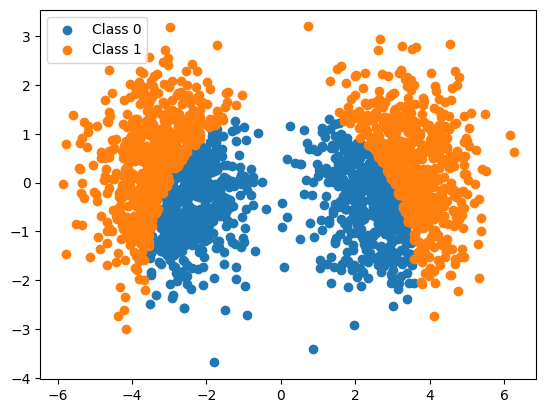

In [189]:
# Visualize the data
# TODO
plt.scatter(data[labels==0, 0], data[labels==0, 1], label='Class 0')
plt.scatter(data[labels==1, 0], data[labels==1, 1], label='Class 1')
plt.legend()
plt.show()

## Expert Model

Task: Implement the Expert model. It should be a simple neural network with one linear layer.



In [190]:
class Expert(nn.Module):
    # TODO
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(2, 1)
    
    def forward(self, x):
        return self.fc(x)


## Gating Network

Task: Implement the Gating Network. It should output the probabilities for choosing each expert.

In [191]:
class GatingNetwork(nn.Module):
  # TODO
  def __init__(self, num_experts):
    super().__init__()
    self.fc = nn.Linear(2, num_experts)
  
  def forward(self, x):
    return F.softmax(self.fc(x), dim=1)



## Mixture of Experts

Task: Implement the Mixture of Experts model. This model should utilize the Expert and Gating Network models to make a final prediction.

In [192]:
class MixtureOfExperts(nn.Module):
  # TODO
  def __init__(self, num_experts=2):
    super().__init__()
    self.experts = nn.ModuleList([Expert() for _ in range(num_experts)])
    # self.experts = [Expert() for _ in range(num_experts)]
    self.gating_network = GatingNetwork(num_experts)

  def forward(self, x):
    g = self.gating_network(x)
    output = torch.zeros(x.shape[0], 1)
    for i, expert in enumerate(self.experts):
      output += g[:, i].view(-1, 1) * expert(x)
    return output
        


## Training Loop

Task: Write a training loop to train the Mixture of Experts model. Use binary cross-entropy loss and an Adam optimizer. Also, implement a learning rate scheduler that decays the learning rate.

In [193]:
# Define the model, loss, and optimizer
model = MixtureOfExperts(num_experts=2) # TODO
criterion = nn.BCEWithLogitsLoss() # TODO 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # TODO

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9) # TODO

# Convert data and labels to float tensors
data_tensor = data.float()
labels_tensor = labels.view(-1, 1).float()

# Training loop
num_epochs = 500 #
for epoch in range(num_epochs):
    # Forward pass
    # TODO
    output = model(data_tensor)

    # Backward pass and optimization
    # TODO
    loss = criterion(output, labels_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Decay the learning rate
    # TODO
    scheduler.step()

    # Print out the loss and accuracy
    if (epoch+1) % 10 == 0:
        accuracy = ((output > 0.5) == labels_tensor).sum().item() / labels_tensor.size(0)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")



Epoch 10/500, Loss: 0.8412, Accuracy: 0.5690
Epoch 20/500, Loss: 0.7241, Accuracy: 0.5890
Epoch 30/500, Loss: 0.6432, Accuracy: 0.6055
Epoch 40/500, Loss: 0.5893, Accuracy: 0.6480
Epoch 50/500, Loss: 0.5540, Accuracy: 0.7585
Epoch 60/500, Loss: 0.5301, Accuracy: 0.8585
Epoch 70/500, Loss: 0.5124, Accuracy: 0.8915
Epoch 80/500, Loss: 0.4983, Accuracy: 0.9035
Epoch 90/500, Loss: 0.4866, Accuracy: 0.9080
Epoch 100/500, Loss: 0.4767, Accuracy: 0.9130
Epoch 110/500, Loss: 0.4683, Accuracy: 0.9155
Epoch 120/500, Loss: 0.4611, Accuracy: 0.9185
Epoch 130/500, Loss: 0.4548, Accuracy: 0.9215
Epoch 140/500, Loss: 0.4493, Accuracy: 0.9205
Epoch 150/500, Loss: 0.4445, Accuracy: 0.9180
Epoch 160/500, Loss: 0.4402, Accuracy: 0.9175
Epoch 170/500, Loss: 0.4364, Accuracy: 0.9185
Epoch 180/500, Loss: 0.4331, Accuracy: 0.9200
Epoch 190/500, Loss: 0.4301, Accuracy: 0.9220
Epoch 200/500, Loss: 0.4275, Accuracy: 0.9225
Epoch 210/500, Loss: 0.4251, Accuracy: 0.9200
Epoch 220/500, Loss: 0.4230, Accuracy: 0.92

## Decision Boundaries
Task: Plot the decision boundaries of the two experts, the gating network and the final model

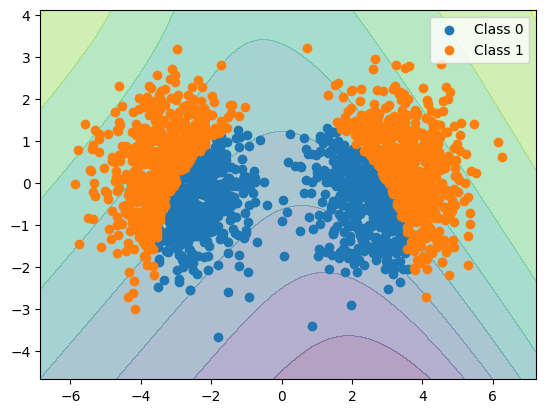

In [194]:
# TODO
# Visualize the decision boundary
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = torch.meshgrid(torch.arange(x_min, x_max, 0.1), torch.arange(y_min, y_max, 0.1))
Z = model(torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1).float())
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z.detach(), alpha=0.4)
plt.scatter(data[labels==0, 0], data[labels==0, 1], label='Class 0')

plt.scatter(data[labels==1, 0], data[labels==1, 1], label='Class 1')
plt.legend()
plt.show()

Question: Analyze the decision boundaries. What differences do you observe between the experts? How does the gating network decide between the two?

## Bonus Task (2 points)
Try increasing the number of experts. How does the model complexity and decision boundary change? (You don't need to show your code for the new models, just plot the new decision boundaries and explain what did you find from the plots)

